In [1]:
#ipynb config
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.cross_validation import train_test_split
from models.cascade_base import CascadeBase
from utils.visualizer import Visualizer
from IPython.display import SVG, display

import numpy as np
import matplotlib.pyplot as plt

import time
import pydot
import lasagne

plt.style.use('ggplot')

%matplotlib notebook

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)
/home/apanin/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [51]:
def get_hex_color(layer_type):
    """
    Determines the hex color for a layer.
    :parameters:
        - layer_type : string
            Class name of the layer
    :returns:
        - color : string containing a hex color for filling block.
    """
    COLORS = ['#4A88B3', '#98C1DE', '#6CA2C8', '#3173A2', '#17649B',
              '#FFBB60', '#FFDAA9', '#FFC981', '#FCAC41', '#F29416',
              '#C54AAA', '#E698D4', '#D56CBE', '#B72F99', '#B0108D',
              '#75DF54', '#B3F1A0', '#91E875', '#5DD637', '#3FCD12']

    hashed = int(hash(layer_type)) % 5

    if "conv" in layer_type.lower():
        return COLORS[:5][hashed]
    if layer_type in lasagne.layers.pool.__all__:
        return COLORS[5:10][hashed]
    if layer_type in lasagne.layers.recurrent.__all__:
        return COLORS[10:15][hashed]
    else:
        return COLORS[15:20][hashed]

def make_pydot_graph(layers, output_shape=True, verbose=False):
    """
    :parameters:
        - layers : list
            List of the layers, as obtained from lasagne.layers.get_all_layers
        - output_shape: (default `True`)
            If `True`, the output shape of each layer will be displayed.
        - verbose: (default `False`)
            If `True`, layer attributes like filter shape, stride, etc.
            will be displayed.
    :returns:
        - pydot_graph : PyDot object containing the graph
    """

    pydot_graph = pydot.Dot('Network', graph_type='digraph')
    pydot_nodes = {}
    pydot_edges = []
    for i, layer in enumerate(layers):
        layer_type = '{0}'.format(layer.__class__.__name__)
        layer_name = layer.name if layer.name is not None else ''
        key = repr(layer)
        label = layer_name + ' ' + layer_type
        color = get_hex_color(layer_type)
        if verbose:
            for attr in ['num_filters', 'num_units', 'ds',
                         'filter_shape', 'stride', 'strides', 'p']:
                if hasattr(layer, attr):
                    label += '\n{0}: {1}'.format(attr, getattr(layer, attr))
            if hasattr(layer, 'nonlinearity'):
                try:
                    nonlinearity = layer.nonlinearity.__name__
                except AttributeError:
                    nonlinearity = layer.nonlinearity.__class__.__name__
                label += '\nnonlinearity: {0}'.format(nonlinearity)

        if output_shape:
            label += '\nOutput shape: {0}'.format(layer.output_shape)

        pydot_nodes[key] = pydot.Node(
            key, label=label, shape='record', fillcolor=color, style='filled')

        if hasattr(layer, 'input_layers'):
            for input_layer in layer.input_layers:
                pydot_edges.append([repr(input_layer), key])

        if hasattr(layer, 'input_layer'):
            pydot_edges.append([repr(layer.input_layer), key])

    for node in pydot_nodes.values():
        pydot_graph.add_node(node)

    for edges in pydot_edges:
        pydot_graph.add_edge(
            pydot.Edge(pydot_nodes[edges[0]], pydot_nodes[edges[1]]))
    return pydot_graph

def iterate_minibatches(inputs, targets, batch_size):
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]

        yield inputs[excerpt], targets[excerpt]


def learn(nn,
          dataset,
          watches=['obj',
                   'recall',
                   'precision',
                   'accuracy',
                   'loss',
                   'sub_loss'],
          num_epochs=100,
          batch_size=50):
    '''
        num_epochs - amount of passes through the data
        batch_size - number of samples processed at each function call
        dataset - [X_train, X_val, y_train, y_val]
    '''
    %matplotlib notebook
    
    X_train, X_val, y_train, y_val = dataset
    metrics_template = dict()
    
    metrics_sample = nn.evaluate(X_val[:2], y_val[:2])
    
    for metric_name, _ in metrics_sample.items():
        if metric_name == 'complexity_parts':
            metrics_template[metric_name] = [0] * len(metrics_sample[metric_name])
        else:
            metrics_template[metric_name] = 0
        
    visualizer = Visualizer(num_epochs,
                            metrics_template,
                            watches=watches)
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        
        train_measurements = dict(metrics_template)
        train_batches = 0

        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.train(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        train_measurements[metric_name][j] += metric[j]
                else: 
                    train_measurements[metric_name] += metric

            train_batches += 1
            
        for metric_name, metric in train_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    train_measurements[metric_name][j] = metric[j] / train_batches
            else: 
                train_measurements[metric_name] = metric / train_batches

        # And a full pass over the validation data:
        val_measurements = dict(metrics_template)
        val_batches = 0

        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.evaluate(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        val_measurements[metric_name][j] += metric[j]
                else: 
                    val_measurements[metric_name] += metric

            val_batches += 1
            
        for metric_name, metric in val_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    val_measurements[metric_name][j] = metric[j] / val_batches
            else: 
                val_measurements[metric_name] = metric / val_batches

        print('Epoch {} of {} took {:.3f}s'.format(epoch + 1, num_epochs, time.time() - start_time))
        visualizer.watch(train_measurements, val_measurements)
    visualizer.finish()
    
def draw(network):
    with open('../images/net.svg', 'w') as f:
        g = make_pydot_graph(lasagne.layers.get_all_layers(network))
        f.write(g.create_svg(f='svg'))

    display(SVG(filename='../images/net.svg'))

In [4]:
dataset = np.load('../data/X.npy')
targets = np.load('../data/targets.npy')

In [5]:
X_y = train_test_split(dataset.reshape(-1, 1, 200, 200).astype(np.float32),
                       targets.reshape(-1, 1, 200, 200).astype(np.float32))

# Simple network

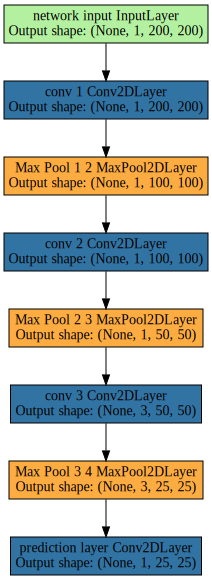

In [10]:
network = CascadeBase(img_shape=(200, 200),
                      learning_rate=1e-3,
                      c=1e-1,
                      c_complexity=0,
                      c_sub_objs=[0, 0],
                      c_sub_obj_cs=[0, 0],
                      mul=False,
                      pool_sizes=[2, 2, 2],
                      num_filters=[1, 1, 3],
                      filter_sizes=[1, 3, 3])

draw(network.output_layer)

<IPython.core.display.Javascript object>


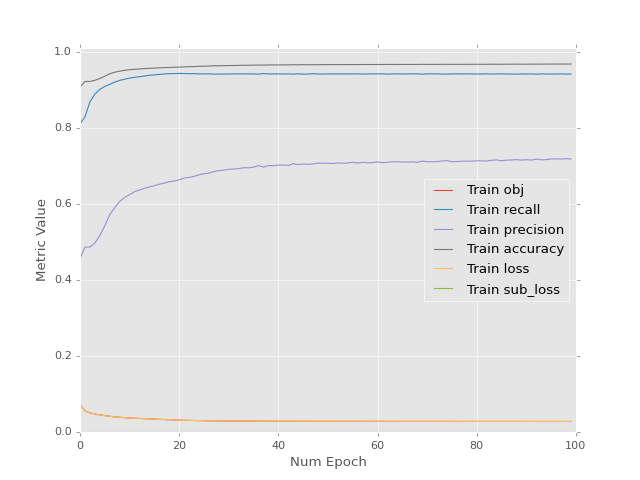

<IPython.core.display.Javascript object>


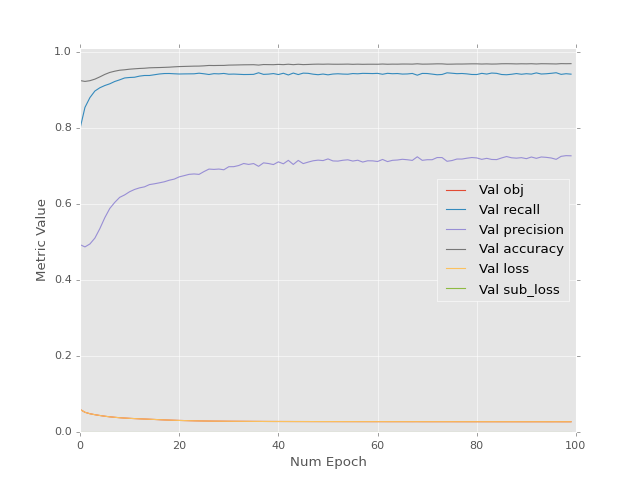

<IPython.core.display.Javascript object>


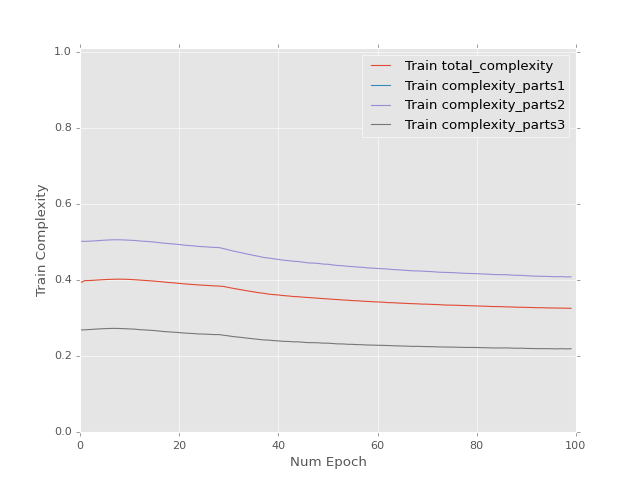

<IPython.core.display.Javascript object>


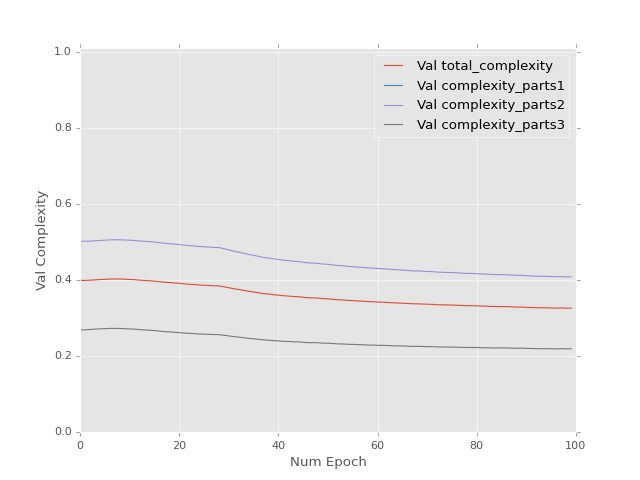

Epoch 1 of 100 took 15.588s
Epoch 2 of 100 took 15.844s
Epoch 3 of 100 took 15.772s
Epoch 4 of 100 took 15.713s
Epoch 5 of 100 took 15.587s
Epoch 6 of 100 took 15.583s
Epoch 7 of 100 took 15.839s
Epoch 8 of 100 took 15.720s
Epoch 9 of 100 took 15.852s
Epoch 10 of 100 took 15.469s
Epoch 11 of 100 took 15.720s
Epoch 12 of 100 took 15.894s
Epoch 13 of 100 took 15.886s
Epoch 14 of 100 took 15.856s
Epoch 15 of 100 took 15.765s
Epoch 16 of 100 took 15.807s
Epoch 17 of 100 took 15.775s
Epoch 18 of 100 took 15.910s
Epoch 19 of 100 took 15.958s
Epoch 20 of 100 took 15.806s
Epoch 21 of 100 took 15.846s
Epoch 22 of 100 took 15.884s
Epoch 23 of 100 took 15.959s
Epoch 24 of 100 took 15.528s
Epoch 25 of 100 took 15.912s
Epoch 26 of 100 took 15.749s
Epoch 27 of 100 took 15.732s
Epoch 28 of 100 took 15.728s
Epoch 29 of 100 took 15.826s
Epoch 30 of 100 took 15.729s
Epoch 31 of 100 took 15.983s
Epoch 32 of 100 took 15.740s
Epoch 33 of 100 took 15.815s
Epoch 34 of 100 took 15.700s
Epoch 35 of 100 took 15

In [11]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=100,
      batch_size=50)

# Improved network

## Sub objs

In [63]:
network = CascadeBase(img_shape=(200, 200),
                      learning_rate=1e-3,
                      c=1e-1,
                      c_complexity=0,
                      c_sub_objs=[1e-2, 1e-1],
                      c_sub_obj_cs=[1e-3, 1e-2],
                      mul=False,
                      pool_sizes=[2, 2, 2],
                      num_filters=[1, 1, 3],
                      filter_sizes=[1, 3, 3])

<IPython.core.display.Javascript object>


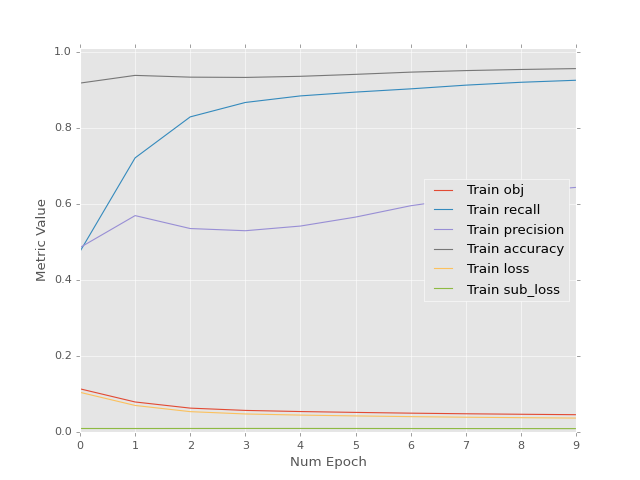

<IPython.core.display.Javascript object>


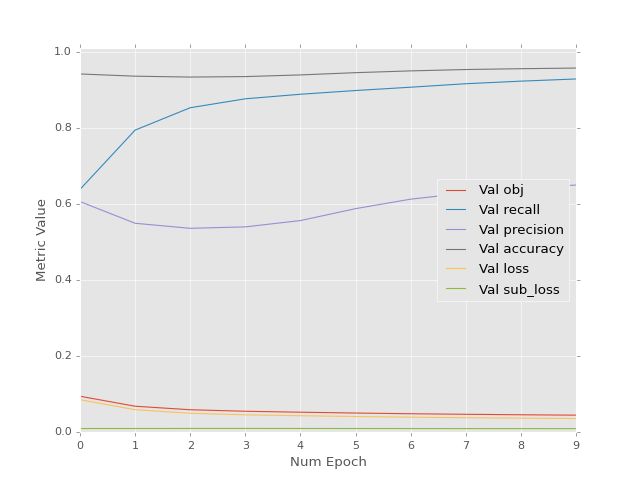

<IPython.core.display.Javascript object>


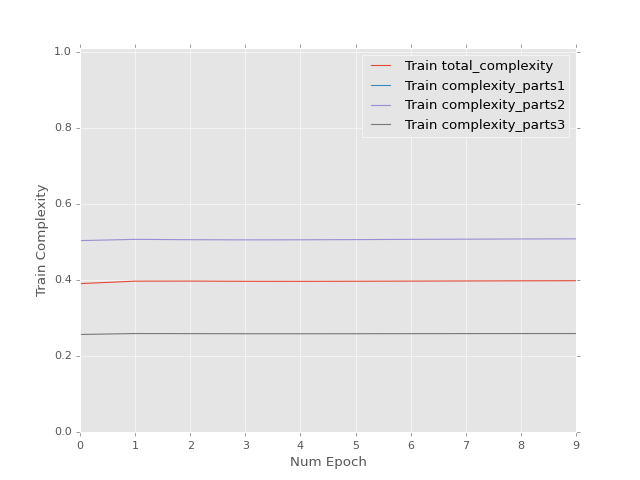

<IPython.core.display.Javascript object>


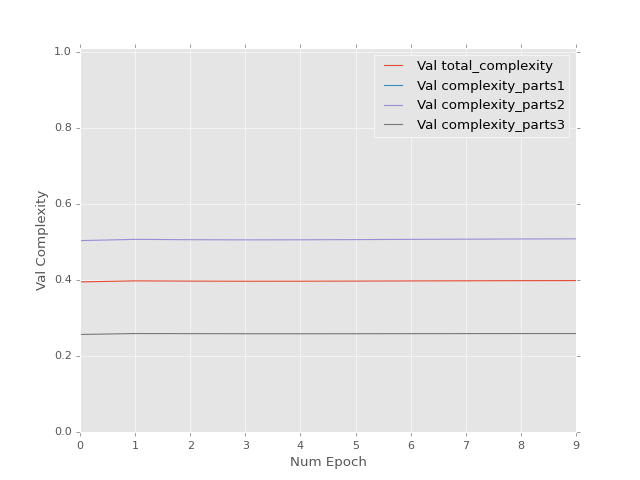

Epoch 1 of 10 took 15.075s
Epoch 2 of 10 took 15.602s
Epoch 3 of 10 took 15.296s
Epoch 4 of 10 took 15.241s
Epoch 5 of 10 took 14.966s
Epoch 6 of 10 took 15.650s
Epoch 7 of 10 took 15.644s
Epoch 8 of 10 took 15.646s
Epoch 9 of 10 took 15.577s
Epoch 10 of 10 took 15.052s


In [64]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=10,
      batch_size=50)

In [65]:
network.save('../weights', 'small_sub_obj')

## Increase importance of sub_obj and add multiplication

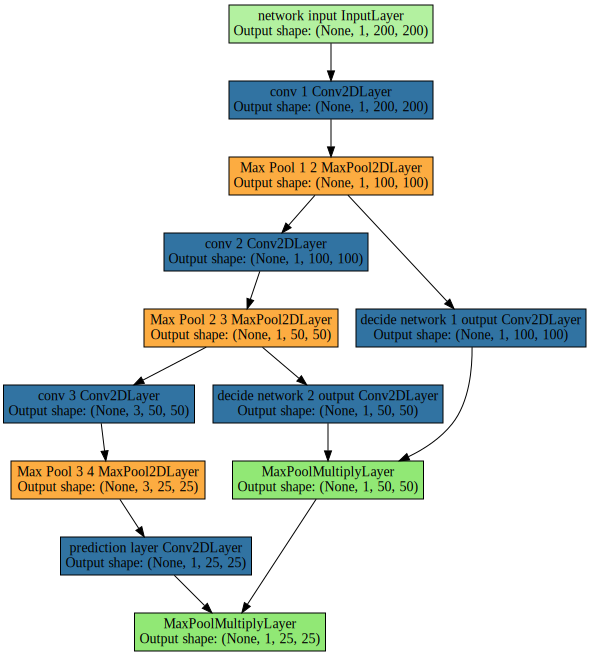

In [66]:
network = CascadeBase(img_shape=(200, 200),
                      learning_rate=1e-3,
                      c=1e-1,
                      c_complexity=0,
                      c_sub_objs=[1, 1],
                      c_sub_obj_cs=[1e-1, 1e-1],
                      mul=True,
                      pool_sizes=[2, 2, 2],
                      num_filters=[1, 1, 3],
                      filter_sizes=[1, 3, 3])
draw(network.output_layer)

In [ ]:
network.load('../weights', 'small_sub_obj')

In [ ]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=100,
      batch_size=50)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
network.save('../weights', 'mul_big_sub_obj')

## Add complexity

In [ ]:
network = CascadeBase(img_shape=(200, 200),
                      learning_rate=1e-3,
                      c=1e-1,
                      c_complexity=1,
                      c_sub_objs=[1, 1],
                      c_sub_obj_cs=[1e-1, 1e-1],
                      mul=True,
                      pool_sizes=[2, 2, 2],
                      num_filters=[1, 1, 3],
                      filter_sizes=[1, 3, 3])

In [ ]:
network.load('../weights', 'mul_big_sub_obj')

In [ ]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=100,
      batch_size=50)

# Check results

/home/apanin/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


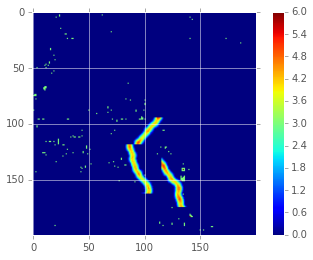

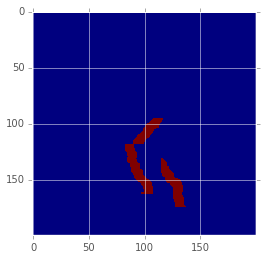

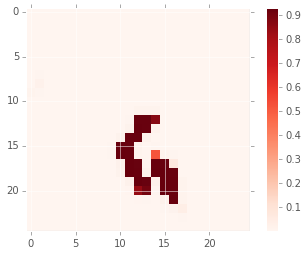

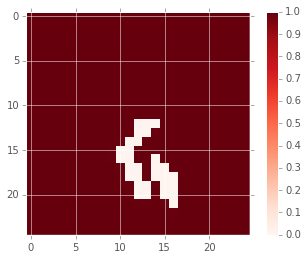

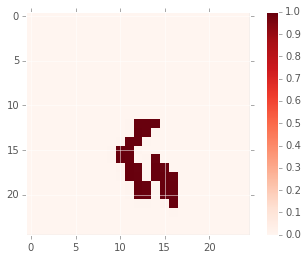

In [46]:
%matplotlib inline
i = 2

plt.imshow(X_y[1][i].reshape((200, 200)))
plt.colorbar()
plt.show()

plt.imshow(X_y[-1][i].reshape((200, 200)), interpolation='none')
plt.show()

prediction = network.predict(X_y[1][i].reshape((1, 1, 200, 200)).astype(np.float32))

plt.imshow(prediction.reshape(25, 25), interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

plt.imshow(prediction.reshape(25, 25) < 0.5, interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

plt.imshow(prediction.reshape(25, 25) >= 0.5, interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()